In [495]:
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import deeppavlov
from deeppavlov.dataset_readers.ontonotes_reader import OntonotesReader
from deeppavlov.models.preprocessors.capitalization import CapitalizationPreprocessor
from deeppavlov.models.embedders.glove_embedder import GloVeEmbedder

### Utility functions

In [496]:
def getNeTagMainPart(tag:str):
    return tag[2:] if tag != 'O' else tag

def tags2binary(tags, symb=True, types:list=None):
    tags = copy.deepcopy(tags)
    for seq in tags:
        for i in range(len(seq)):
            ne = False
            if seq[i] != 'O':
                ne = True
            if types and getNeTagMainPart(seq[i]) not in types:
                ne = False
            if symb:
                seq[i] = 'T' if ne else 'O'
            else:
                seq[i] = 1 if ne else 0
    return tags

def to_lower_case(tokens:list):
    tokens_lower = []
    for seq in tokens:
        tokens_lower.append([])
        for token in seq:
            tokens_lower[-1].append(token.lower())
    return tokens_lower

def get_tokens_len(tokens):
    if isinstance(tokens[0], str):
        tokens = [tokens]
    return [len(seq) for seq in tokens]

def add_padding(tokens:list):
    if isinstance(tokens[0], str):
        return tokens, len(tokens)
    elif isinstance(tokens[0], list):
        tokens = copy.deepcopy(tokens)
        max_len = 0
        for seq in tokens:
            if len(seq) > max_len:
                max_len = len(seq)
        for seq in tokens:
            i = len(seq)
            while i < max_len:
                seq.append('')
                i += 1
        return tokens
    else:
        raise Exception('tokens should be either list of strings or list of lists of strings')
        
def flatten_list(ar:list):
    flat = []
    for sublist in ar:
        flat += sublist
    return flat

def select_list_elements(ar:list, indices:list):
    return [ar[i] for i in indices]

### Read data

In [497]:
reader = OntonotesReader()
dataset = reader.read(data_path='data/')
print(dataset.keys())
print('Num of train sentences: {}'.format(len(dataset['train'])))
print('Num of test sentences: {}'.format(len(dataset['test'])))

dict_keys(['train', 'valid', 'test'])
Num of train sentences: 75187
Num of test sentences: 9479


### Drop train sentences with no named entities

In [498]:
dataset_sanitized = []
for example in dataset['train']:
    tags = example[1]
    if any(map(lambda t: t != 'O', tags)):
        dataset_sanitized.append(example)
dataset['train'] = dataset_sanitized
print('Num of train sentences with at least one NE: {}'.format(len(dataset['train'])))

Num of train sentences with at least one NE: 33120


### Select sentences with chosen NE types only

In [499]:
def filter_data_by_ne_type(data:list, ne_types:list):
    if ne_types == None or len(ne_types) == 0:
        return data
    data_filtered = []
    for tokens,tags in data:
        contains_all = True
        tags_norm = [getNeTagMainPart(t) for t in tags]
        for ne_type in ne_types:
            if not ne_type in tags_norm:
                contains_all = False
                break
        if contains_all:
            data_filtered.append((tokens,tags))
    return data_filtered

### Select few examples

In [500]:
ne_types = ['PERSON']
n_examples = 5
# np.random.seed(12)
dataset_filtered = filter_data_by_ne_type(dataset['train'], ne_types)
print('Num of train sentences with all NE types from {}: {}'.format(len(dataset_filtered), ne_types))
indices = np.random.choice(len(dataset_filtered), size=n_examples)
examples = [dataset_filtered[i] for i in indices]
print(examples)

Num of train sentences with all NE types from 33120: []
[(['Last', 'October', ',', 'during', 'the', '1988', 'Summer', 'Games', ',', 'NBC', 'relentlessly', 'pitched', 'a', 'new', 'series', ',', '``', 'Tattingers', '.', "''"], ['B-DATE', 'I-DATE', 'O', 'O', 'O', 'B-DATE', 'B-EVENT', 'I-EVENT', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-WORK_OF_ART', 'O', 'O']), (['but', 'Laura', 'was', 'able', 'to', 'help', 'her', 'with', 'the', 'book', 'a', 'bit', ',', 'you', 'know', 'by', 'her', 'sort', 'of', 'secretly', 'wanting', 'her', 'to', 'read', 'it', '.', 'and', 'tell', 'what', 'sections', 'are', 'where'], ['O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['To', 'date', ',', 'no', 'one', 'has', 'been', 'able', 'to', 'surpass', 'the', 'securities', 'service', 'model', 'I', 'designed', 'four', 'years', 'ago', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

### Split tokens and tags

In [501]:
def split_tokens_tags(dataset: list):
    tokens = []
    tags = []
    for sample in dataset:
        tokens.append(sample[0])
        tags.append(sample[1])
    return tokens, tags

In [502]:
tokens_train,tags_train = split_tokens_tags(examples)
# print(tags_train)

In [503]:
def calc_data_props(tokens:list, tags:list):
    props = {}
    props['ne_types'] = {}
    tokens_flat = flatten_list(tokens)
    tags_flat = flatten_list(tags)
    ne_count = 0
    for tag in tags_flat:
        if tag != 'O':
            ne_count += 1
            tag_main = tag[2:]
            if props['ne_types'].get(tag_main) != None:
                props['ne_types'][tag_main] += 1
            else:
                props['ne_types'][tag_main] = 1
    props['tokens_count'] = len(tokens_flat)
    props['ne_count'] = ne_count
    props['ne_ratio'] = props['ne_count']/props['tokens_count']
    for k in props['ne_types'].keys():   
        props['ne_types'][k] /= ne_count
        
    return props
        
def print_data_props(props:dict):
    s = ''
    s += '#tokens = {}, '.format(props['tokens_count'])
    s += '#ne = {} '.format(props['ne_count'])
    s += '('
    for k, v in props['ne_types'].items():
        if v != 0:
            s += '{}: {:.3f}, '.format(k,v)
    s += '), '
    s += '#ne/#tokens = {:.3f}, '.format(props['ne_ratio'])
    print(s)

In [504]:
print_data_props(calc_data_props(tokens_train,tags_train))

#tokens = 120, #ne = 24 (DATE: 0.583, EVENT: 0.083, ORG: 0.042, WORK_OF_ART: 0.042, PERSON: 0.083, NORP: 0.125, GPE: 0.042, ), #ne/#tokens = 0.200, 


### Elmo wrapper class

In [505]:
class ElmoEmbedder():
    def __init__(self):
        self.elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        self.sess = sess

    def get_tokens_embeddings(self, tokens_input: list, tokens_length:list=None):
        if not tokens_length:
            if isinstance(tokens_input[0], list):
                tokens_length = [len(seq) for seq in tokens_input]
            else:
                tokens_length = len(tokens_input)
        embeddings = self.elmo(
                        inputs={
                            "tokens": tokens_input,
                            "sequence_len": tokens_length
                        },
                        signature="tokens",
                        as_dict=True)["elmo"]
        embeddings = self.sess.run([embeddings])
        return embeddings[0]

### Transform NER to binary classification

In [506]:
tags_train_orig = tags_train
tags_train = tags2binary(tags_train, types=ne_types)

### Count how many named entities in support set

In [507]:
tokens_train_flat = flatten_list(tokens_train)
tags_train_flat = flatten_list(tags_train)
ne_train_count = 0
for tag in tags_train_flat:
    if tag == 'T':
        ne_train_count += 1
print('Count of tokens in support set {}'.format(len(tokens_train_flat)))
print('Count of named entities in support set {}'.format(ne_train_count))
print('ratio #NE/#tokens = {:.4f}'.format(ne_train_count/len(tokens_train_flat)))

Count of tokens in support set 120
Count of named entities in support set 24
ratio #NE/#tokens = 0.2000


### Main embedder

In [508]:
class CompositeEmbedder():
    def __init__(self, use_elmo=True, elmo_scale=1., use_cap_feat=False, use_glove=False):
        self.use_elmo = use_elmo
        self.elmo_scale = elmo_scale
        self.use_cap_feat = use_cap_feat
        self.use_glove = use_glove
        if self.use_elmo:
            self.elmo = ElmoEmbedder()
        if self.use_cap_feat:
            self.cap_prep = CapitalizationPreprocessor()
        if self.use_glove:
            self.glove = GloVeEmbedder('embeddings/glove.6B/glove.6B.100d.txt', pad_zero=True)
        
    def embed(self, tokens: list):
        if isinstance(tokens[0], str):
            tokens = [tokens]
        # Get ELMo embeddings
        if self.use_elmo:
            tokens_input = add_padding(tokens)
            tokens_length = get_tokens_len(tokens)
            embeddings = self.elmo.get_tokens_embeddings(tokens_input, tokens_length)
            embeddings *= self.elmo_scale
            embed_size = embeddings.shape[-1]
#             print(embeddings.shape)
#             print(embed_size)

        # Use capitalization features
        if self.use_cap_feat:
#             print('Use capitalization features')
            cap_features = self.cap_prep(tokens)
    #         print(cap_features)
#             print(cap_features.shape)
            embeddings = np.concatenate((embeddings, cap_features), axis=2)
            embed_size = embeddings.shape[-1]
#             print(embeddings.shape)

        # Use GloVe embeddings
        if self.use_glove:
#             print('Use GloVe')
            
            glove_embed = self.glove(to_lower_case(tokens))
            glove_embed = np.array(glove_embed)
            if not self.use_elmo:
                embeddings = glove_embed
            else: 
                embeddings = np.concatenate((embeddings, glove_embed), axis=2)
            embed_size = embeddings.shape[-1]
#             print(embeddings.shape)
        
        return embeddings

### Calculate similarity of token embedding vector to some prototype (centroid) or just support vector

In [509]:
def calc_sim(token_vec, support_vec)->dict:
    sim = {}
    sim['euc_dist'] = np.linalg.norm(token_vec - support_vec)
    sim['dot_prod'] = np.dot(token_vec, support_vec)
    sim['cosine'] = np.dot(token_vec, support_vec)/(np.linalg.norm(token_vec)*np.linalg.norm(support_vec)) if np.linalg.norm(support_vec) != 0 else 0
    return sim

In [510]:
def calc_sim_batch(tokens: list, embeddings: np.ndarray, support_vec: np.ndarray)->list:
    sim_list = []
    tokens_length = get_tokens_len(tokens)
    for i in range(len(tokens_length)):
        sim_list.append([])
        for j in range(tokens_length[i]):
            token_vec = embeddings[i,j,:]
            sim_list[i].append(calc_sim(token_vec, support_vec))
    return sim_list

In [511]:
def flatten_sim(sim_list):
    sims_flat = {'euc_dist': [], 'dot_prod': [], 'cosine': []}
    for i in range(len(sim_list)):
        for j in range(len(sim_list[i])):
            for sim_type in ['euc_dist', 'dot_prod', 'cosine']:
                sims_flat[sim_type].append(sim_list[i][j][sim_type])
    for sim_type in ['euc_dist', 'dot_prod', 'cosine']:
        sims_flat[sim_type] = np.array(sims_flat[sim_type])
    return sims_flat

### Calculate centroid for named entities embedding vectors

In [512]:
def calc_ne_centroid_vec(tokens: list, tags: list, embeddings: np.ndarray=None, embedder: CompositeEmbedder=None):

    # Calculate embeddings
    if embedder != None:
        embeddings = embedder.embed(tokens)

    # Calculate average vector for ne-tags
    embed_size = embeddings.shape[-1]
    ne_prototype = np.zeros((embed_size,))
    tokens_length = get_tokens_len(tokens)
    tags_bin = np.array(flatten_list(tags2binary(tags, symb=False)))
#     print(tags_bin)
    n_ne_tags = np.sum(tags_bin == 1)
    embeddings_ne_flat = np.zeros((n_ne_tags, embed_size))
#     print(n_ne_tags)
#     n_ne_tags = 0
    k = 0
    for i in range(len(tokens_length)):
        for j in range(tokens_length[i]):
            if tags[i][j] == 'T':
                ne_prototype += embeddings[i,j,:].reshape((embed_size,))
                embeddings_ne_flat[k,:] = embeddings[i,j,:]
                k += 1   # TODO: Change this to some better approach
#                 n_ne_tags += 1
    if n_ne_tags != 0:
        ne_prototype /= n_ne_tags
#     print('ne mean vector: {}'.format(ne_prototype))
    
    # Calculate similarities
    sim_list = calc_sim_batch(tokens, embeddings, ne_prototype)

    return ne_prototype, sim_list, embeddings, embeddings_ne_flat

### Calculate similarities of some test tokens to NE prototype

In [513]:
def calc_sim_to_ne_prototype(tokens: list, ne_prototype: np.ndarray, embeddings: np.ndarray=None, embedder: CompositeEmbedder=None):
    if isinstance(tokens[0], str):
        tokens = [tokens]
    
    tokens_length = get_tokens_len(tokens)
    
    # Calculate embeddings
    if embedder != None:
        embeddings = embedder.embed(tokens)
    
    # Calculate similarities
    sim_list = calc_sim_batch(tokens, embeddings, ne_prototype)
    
    return sim_list, embeddings

In [514]:
def calc_sim_to_ne_nearest(tokens: list, ne_support_embeddings: np.ndarray, embeddings: np.ndarray=None, embedder: CompositeEmbedder=None):
    if isinstance(tokens[0], str):
        tokens = [tokens]
    
    tokens_length = get_tokens_len(tokens)
    
    # Calculate embeddings
    if embedder != None:
        embeddings = embedder.embed(tokens)
    
    # Calculate similarities
    n_supports = ne_support_embeddings.shape[0]
    sim_list = []
    tokens_length = get_tokens_len(tokens)
    for i in range(len(tokens_length)):
        sim_list.append([])
        for j in range(tokens_length[i]):
            token_vec = embeddings[i,j,:]
            sim_token_list = {'euc_dist': [], 'dot_prod': [], 'cosine': []}
            for k in range(n_supports):
                sim = calc_sim(token_vec, ne_support_embeddings[k, :])
                for sim_type in ['euc_dist', 'dot_prod', 'cosine']:
                    sim_token_list[sim_type].append(sim[sim_type])
            sim_list[i].append({'euc_dist': np.min(np.array(sim_token_list['euc_dist'])), 
                                'dot_prod': np.max(np.array(sim_token_list['dot_prod'])), 
                                'cosine': np.max(np.array(sim_token_list['cosine']))})
            
    return sim_list, embeddings
    

### Embedder initialization

In [515]:
embedder = CompositeEmbedder(use_elmo=True, elmo_scale=1, use_cap_feat=True, use_glove=True)

INFO:tensorflow:Initialize variable module_11/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling


2018-08-08 20:07:44.343 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling


INFO:tensorflow:Initialize variable module_11/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights


2018-08-08 20:07:44.358 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights


INFO:tensorflow:Initialize variable module_11/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0


2018-08-08 20:07:44.365 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0


INFO:tensorflow:Initialize variable module_11/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_1


2018-08-08 20:07:44.372 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_1


INFO:tensorflow:Initialize variable module_11/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_2


2018-08-08 20:07:44.378 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_2


INFO:tensorflow:Initialize variable module_11/bilm/CNN/W_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_3


2018-08-08 20:07:44.387 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN/W_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_3


INFO:tensorflow:Initialize variable module_11/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4


2018-08-08 20:07:44.393 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4


INFO:tensorflow:Initialize variable module_11/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5


2018-08-08 20:07:44.401 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5


INFO:tensorflow:Initialize variable module_11/bilm/CNN/W_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_6


2018-08-08 20:07:44.408 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN/W_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_6


INFO:tensorflow:Initialize variable module_11/bilm/CNN/b_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_0


2018-08-08 20:07:44.416 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN/b_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_0


INFO:tensorflow:Initialize variable module_11/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1


2018-08-08 20:07:44.425 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1


INFO:tensorflow:Initialize variable module_11/bilm/CNN/b_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_2


2018-08-08 20:07:44.436 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN/b_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_2


INFO:tensorflow:Initialize variable module_11/bilm/CNN/b_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_3


2018-08-08 20:07:44.443 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN/b_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_3


INFO:tensorflow:Initialize variable module_11/bilm/CNN/b_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_4


2018-08-08 20:07:44.449 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN/b_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_4


INFO:tensorflow:Initialize variable module_11/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5


2018-08-08 20:07:44.455 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5


INFO:tensorflow:Initialize variable module_11/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6


2018-08-08 20:07:44.464 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6


INFO:tensorflow:Initialize variable module_11/bilm/CNN_high_0/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_carry


2018-08-08 20:07:44.471 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN_high_0/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_carry


INFO:tensorflow:Initialize variable module_11/bilm/CNN_high_0/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_transform


2018-08-08 20:07:44.479 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN_high_0/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_transform


INFO:tensorflow:Initialize variable module_11/bilm/CNN_high_0/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_carry


2018-08-08 20:07:44.485 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN_high_0/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_carry


INFO:tensorflow:Initialize variable module_11/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_transform


2018-08-08 20:07:44.494 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_transform


INFO:tensorflow:Initialize variable module_11/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry


2018-08-08 20:07:44.508 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry


INFO:tensorflow:Initialize variable module_11/bilm/CNN_high_1/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_transform


2018-08-08 20:07:44.516 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN_high_1/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_transform


INFO:tensorflow:Initialize variable module_11/bilm/CNN_high_1/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_carry


2018-08-08 20:07:44.523 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN_high_1/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_carry


INFO:tensorflow:Initialize variable module_11/bilm/CNN_high_1/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_transform


2018-08-08 20:07:44.530 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN_high_1/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_transform


INFO:tensorflow:Initialize variable module_11/bilm/CNN_proj/W_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/W_proj


2018-08-08 20:07:44.536 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN_proj/W_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/W_proj


INFO:tensorflow:Initialize variable module_11/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj


2018-08-08 20:07:44.542 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj


INFO:tensorflow:Initialize variable module_11/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


2018-08-08 20:07:44.548 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_11/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


2018-08-08 20:07:44.553 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_11/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


2018-08-08 20:07:44.561 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_11/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


2018-08-08 20:07:44.573 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_11/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


2018-08-08 20:07:44.586 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_11/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


2018-08-08 20:07:44.593 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_11/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


2018-08-08 20:07:44.598 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_11/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


2018-08-08 20:07:44.605 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_11/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


2018-08-08 20:07:44.613 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_11/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


2018-08-08 20:07:44.620 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_11/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


2018-08-08 20:07:44.628 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_11/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


2018-08-08 20:07:44.634 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_11/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed


2018-08-08 20:07:44.644 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_11/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed
2018-08-08 20:08:26.170 INFO in 'deeppavlov.models.embedders.glove_embedder'['glove_embedder'] at line 60: [loading embeddings from `/home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt`]
2018-08-08 20:08:26.638 INFO in 'gensim.models.keyedvectors'['keyedvectors'] at line 204: loading projection weights from /home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt
2018-08-08 20:08:26.704 DEBUG in 'smart_open.smart_open_lib'['smart_open_lib'] at line 176: {'kw': {}, 'mode': 'rb', 'uri': '/home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt'}
2018-08-08 20:09:56.990 INFO in 'gensim.models.keyedvectors'['keyedvectors'] at line 266: loaded (400000, 100) m

### Calculate NE centroid for support examples

In [516]:
ne_prototype, _, _, ne_support_embeddings = calc_ne_centroid_vec(tokens_train, tags_train, embedder=embedder)
print(ne_support_embeddings.shape)

(24, 1128)


### Select some unlabeled examples from the test set and estimate similarity to a named entity for each token

In [517]:
n_test_sentences = 100
# np.random.seed(44)
indices_test = np.random.choice(len(dataset['test']), size=n_test_sentences)
test_sentences = select_list_elements(dataset['test'], indices_test)
tokens_test,tags_test = split_tokens_tags(test_sentences)
print_data_props(calc_data_props(tokens_test,tags_test))
# print(tokens_test)
# print(tags_test)

#tokens = 1925, #ne = 251 (PERSON: 0.171, EVENT: 0.028, ORG: 0.347, DATE: 0.147, GPE: 0.143, CARDINAL: 0.040, NORP: 0.032, ORDINAL: 0.012, PRODUCT: 0.004, MONEY: 0.040, LANGUAGE: 0.004, FAC: 0.008, PERCENT: 0.012, WORK_OF_ART: 0.012, ), #ne/#tokens = 0.130, 


In [518]:
tags_test_bin_flat = np.array(flatten_list(tags2binary(tags_test, symb=False, types=ne_types)))

In [519]:
sim_list_test = {}
sim_list_test['centroid'], _ = calc_sim_to_ne_prototype(tokens_test, ne_prototype, embedder=embedder)
sim_list_test['nearest'], _ = calc_sim_to_ne_nearest(tokens_test, ne_support_embeddings, embedder=embedder)

### Group similarities with tokens

In [520]:
def zip_tokens_sim(tokens: list, sim_list: list, sim_type='cosine'):
    tokens_sim = []
    for i in range(len(tokens)):
        tokens_sim.append([])
        for j in range(len(tokens[i])):
            tokens_sim[-1].append((tokens[i][j], sim_list[i][j][sim_type]))
    return tokens_sim

In [521]:
tokens_test_sim = {}
tokens_test_sim['centroid'] = zip_tokens_sim(tokens_test, sim_list_test['centroid'])
tokens_test_sim['nearest'] = zip_tokens_sim(tokens_test, sim_list_test['nearest'])

### Print test sentences with NE similarities estimations

In [522]:
def decorate_ne_token(token, tag):
    if tag == 'T':
        token = '[[' + token + ']]'
    return token
def format_labeled_examples(tokens_input: list, tags_input: list):
    s = '+++++++++ Input examples +++++++++\n\n'
    for i in range(len(tokens_input)):
        for j in range(len(tokens_input[i])):
            s += decorate_ne_token(tokens_input[i][j], tags_input[i][j]) + ' '
        s += '\n\n'
    return s

In [523]:
def format_inference_results(tokens_sim: list):
    s = '+++++++++ Tests +++++++++\n\n'
    for seq in tokens_sim:
        for token, sim in seq:
            s += '{}[{:.3f}]'.format(token, sim)
            s += ' '
        s += '\n\n'
    return s

In [524]:
text = ''
text += format_labeled_examples(tokens_train, tags_train)
text += format_inference_results(tokens_test_sim['centroid'])
print(text)

+++++++++ Input examples +++++++++

[[Last]] [[October]] , during the [[1988]] [[Summer]] [[Games]] , [[NBC]] relentlessly pitched a new series , `` [[Tattingers]] . '' 

but [[Laura]] was able to help her with the book a bit , you know by her sort of secretly wanting her to read it . and tell what sections are where 

To date , no one has been able to surpass the securities service model I designed [[four]] [[years]] [[ago]] . 

[[Lien]] has stated that he wants to extend compulsory education from [[9]] [[to]] [[12]] [[years]] , and to offer vouchers for pre-school and private secondary education . 

[[July]] [[23rd]] [[,]] [[1999]] -- there was a massive drug bust in a predominately [[African]] [[-]] [[American]] neighborhood in [[Tulia]] . 

+++++++++ Tests +++++++++

Before[0.409] I[0.354] left[0.340] ,[0.422] he[0.414] had[0.328] to[0.291] explain[0.243] to[0.303] me[0.334] that[0.400] his[0.343] supplier[0.222] was[0.337] none[0.283] other[0.304] than[0.326] Freddie[0.265] Feelup

In [525]:
text = ''
text += format_labeled_examples(tokens_train, tags_train)
text += format_inference_results(tokens_test_sim['nearest'])
print(text)

+++++++++ Input examples +++++++++

[[Last]] [[October]] , during the [[1988]] [[Summer]] [[Games]] , [[NBC]] relentlessly pitched a new series , `` [[Tattingers]] . '' 

but [[Laura]] was able to help her with the book a bit , you know by her sort of secretly wanting her to read it . and tell what sections are where 

To date , no one has been able to surpass the securities service model I designed [[four]] [[years]] [[ago]] . 

[[Lien]] has stated that he wants to extend compulsory education from [[9]] [[to]] [[12]] [[years]] , and to offer vouchers for pre-school and private secondary education . 

[[July]] [[23rd]] [[,]] [[1999]] -- there was a massive drug bust in a predominately [[African]] [[-]] [[American]] neighborhood in [[Tulia]] . 

+++++++++ Tests +++++++++

Before[0.528] I[0.340] left[0.291] ,[0.507] he[0.386] had[0.261] to[0.286] explain[0.234] to[0.301] me[0.267] that[0.324] his[0.289] supplier[0.193] was[0.274] none[0.289] other[0.263] than[0.283] Freddie[0.299] Feelup

### Visualize similarities of tokens to NE

In [526]:
from IPython.core.display import display, HTML

In [527]:
def get_color(red=0, green=255, blue=0):
    return {'r': red, 'g': green, 'b': blue}

def get_rgba_str(color, alpha=1):
    return 'rgba({},{},{},{})'.format(color['r'], color['g'], color['b'], alpha)

def get_token_span_str(token, color, cf=1):
    return '<span style="padding: 0.15em; margin-right: 4px; border-radius: 0.25em; background: {};">{}</span>'.format(get_rgba_str(color, alpha=cf), token)

def wrap_with_style(html):
    return '<div style="line-height: 1.5em;">{:s}</div>'.format(html)

In [528]:
bg_color = get_color(red=0, green=255, blue=0)
display(HTML(get_token_span_str('token', bg_color, cf=0.7)))

In [529]:
def calc_sim_min_max(sim_list):
    sim_flat = flatten_sim(sim_list)
    sim_min = np.min(sim_flat['cosine'])
    sim_max = np.max(sim_flat['cosine'])
    return sim_min, sim_max

In [530]:
def sim_transform_lin(sim, sim_min, sim_max):
    # similarity transformation for better visualization
    return (sim - sim_min)/(sim_max - sim_min)
def sim_transform(sim, sim_min, sim_max, T=0.5):
    # similarity transformation with temperature for better visualization
    return (np.exp(sim/T) - np.exp(sim_min/T))/(np.exp(sim_max/T) - np.exp(sim_min/T))

In [531]:
def get_colored_results_html(tokens_sim: list, sim_list: list, color, T=0.5):
    sim_min, sim_max = calc_sim_min_max(sim_list)
    s = '<h3 style="margin-bottom:0.3em;">Visualization of tokens to NE similarities on test set:</h3>'
    for seq in tokens_sim:
        for token, sim in seq:
            s += get_token_span_str(token, color, cf=sim_transform(sim, sim_min, sim_max, T))
#             s += ' '
        s += '<br/><br/>'
    return wrap_with_style(s)

In [532]:
display(HTML(get_colored_results_html(tokens_test_sim['centroid'], sim_list_test['centroid'], bg_color)))

In [533]:
display(HTML(get_colored_results_html(tokens_test_sim['nearest'], sim_list_test['nearest'], bg_color)))

### Plot histograms of test similarities

(1630,)
(295,)
(1630,)
(295,)


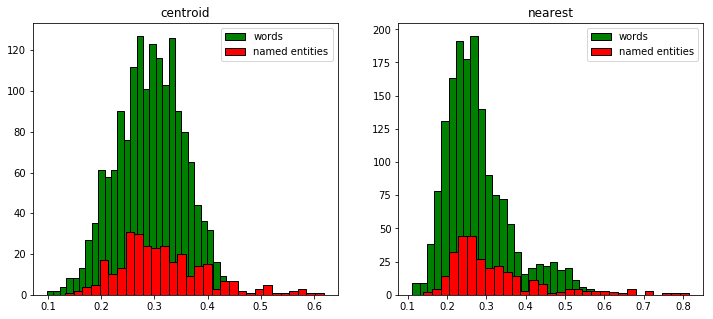

In [534]:
sim_test_words = {}
sim_test_ne = {}
plt.figure(figsize=(12,5))
for i, method in enumerate(['centroid', 'nearest']):
    sim_flat = np.array(flatten_sim(sim_list_test[method])['cosine'])
    sim_test_words[method] = sim_flat[tags_test_bin_flat == 0]
    sim_test_ne[method] = sim_flat[tags_test_bin_flat == 1]
    print(sim_test_words[method].shape)
    print(sim_test_ne[method].shape)
    plt.subplot(1, 2, i+1, title=method)
    plt.hist(sim_test_words[method], color = 'green', edgecolor = 'black',
         bins = 30, label='words')
    plt.hist(sim_test_ne[method], color = 'red', edgecolor = 'black',
             bins = 30, label='named entities')
    plt.legend()

### Plot probability densities

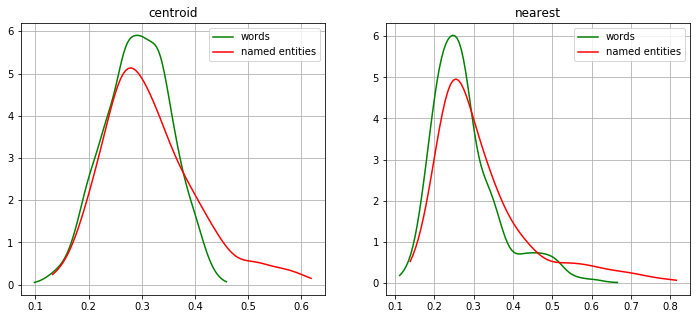

In [535]:
# https://stackoverflow.com/questions/15415455/plotting-probability-density-function-by-sample-with-matplotlib
from scipy.stats.kde import gaussian_kde
from numpy import linspace
plt.figure(figsize=(12,5))
for i, method in enumerate(['centroid', 'nearest']):
    kde_words = gaussian_kde( sim_test_words[method] )
    dist_space_words = linspace( min(sim_test_words[method]), max(sim_test_words[method]), 100 )
    kde_ne = gaussian_kde( sim_test_ne[method] )
    dist_space_ne = linspace( min(sim_test_ne[method]), max(sim_test_ne[method]), 100 )
    plt.subplot(1, 2, i+1, title=method)
    plt.plot( dist_space_words, kde_words(dist_space_words), color='green', label='words' )
    plt.plot( dist_space_ne, kde_ne(dist_space_ne), color='red',  label='named entities' )
    plt.legend(loc='upper right')
    plt.grid()
#     plt.title('Probability densities')

### F1 score

In [536]:
def infer_tags(sim_list, sim_type, sim_min, sim_max, threshold=0.5):
    T = 1.0
    tokens_length = get_tokens_len(sim_list)
    tags = [['T' if sim_transform(sim_list[i][j][sim_type], sim_min, sim_max, T)  > threshold else 'O' for j in range(tokens_length[i])] for i in range(len(tokens_length))]
    return tags

In [537]:
from sklearn.metrics import f1_score
f1 = {}
for i, method in enumerate(['centroid', 'nearest']):
    sim_list = sim_list_test[method]
    sim_min, sim_max = calc_sim_min_max(sim_list)
    tags_test_pred = infer_tags(sim_list, 'cosine', sim_min, sim_max)
    target = flatten_list(tags2binary(tags_test, symb=False, types=ne_types))
    pred = flatten_list(tags2binary(tags_test_pred, symb=False))
    f1[method] = f1_score(target, pred)
print(f1)

{'centroid': 0.24074074074074076, 'nearest': 0.1511627906976744}


In [538]:
print('Train:')
print_data_props(calc_data_props(tokens_train,tags_train_orig))
print('Test:')
print_data_props(calc_data_props(tokens_test,tags_test))

Train:
#tokens = 120, #ne = 24 (DATE: 0.583, EVENT: 0.083, ORG: 0.042, WORK_OF_ART: 0.042, PERSON: 0.083, NORP: 0.125, GPE: 0.042, ), #ne/#tokens = 0.200, 
Test:
#tokens = 1925, #ne = 251 (PERSON: 0.171, EVENT: 0.028, ORG: 0.347, DATE: 0.147, GPE: 0.143, CARDINAL: 0.040, NORP: 0.032, ORDINAL: 0.012, PRODUCT: 0.004, MONEY: 0.040, LANGUAGE: 0.004, FAC: 0.008, PERCENT: 0.012, WORK_OF_ART: 0.012, ), #ne/#tokens = 0.130, 
